<a href="https://colab.research.google.com/github/Kals-13/Memes-vs-Notes/blob/master/MvsN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os 
import cv2

In [2]:
torch.device('cuda:0')

device(type='cuda', index=0)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
path0 = "/content/gdrive/My Drive/Memes"
path1 = "/content/gdrive/My Drive/Notes"

In [5]:
images0 = []
for img in os.listdir(path0):
  image = cv2.imread(os.path.join(path0, img), cv2.IMREAD_UNCHANGED)
  images0.append([image, 0])

In [6]:
images1 = []
for img in os.listdir(path1):
  image = cv2.imread(os.path.join(path1, img), cv2.IMREAD_UNCHANGED)
  images1.append([image, 1])

In [7]:
test_set = images0[:48] + images1[:48]
validation_set = images0[48:80] + images1[48:80]
training_set = images0[80:] + images1[80:]

In [8]:
import random
random.seed(5)

random.shuffle(training_set)
random.shuffle(test_set)
random.shuffle(validation_set)

In [9]:
train_X = []
train_Y = []
for features, label in training_set:
  train_X.append(features)
  train_Y.append(label)
train_X = torch.tensor(np.array(train_X))
train_X = train_X.permute(0, 3, 1, 2)
m = train_X.shape[0]
train_Y = torch.tensor(np.array(np.reshape(train_Y, (m, 1))))

In [10]:
validation_X = []
validation_Y = []
for features, label in validation_set:
  validation_X.append(features)
  validation_Y.append(label)
validation_X = torch.tensor(np.array(validation_X))
validation_X = validation_X.permute(0, 3, 1, 2)
m = validation_X.shape[0]
validation_Y = torch.tensor(np.array(np.reshape(validation_Y, (m, 1))))

In [11]:
test_X = []
test_Y = []
for features, label in test_set:
  test_X.append(features)
  test_Y.append(label)
test_X = torch.tensor(np.array(test_X))
test_X = test_X.permute(0, 3, 1, 2)
m = test_X.shape[0]
test_Y = torch.tensor(np.array(np.reshape(test_Y, (m, 1))))

In [12]:
train_X = torch.true_divide(train_X, 256)
validation_X = torch.true_divide(validation_X, 256)
test_X = torch.true_divide(test_X, 256)

In [13]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 20, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(20, 40, kernel_size=5, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.fc1 = nn.Linear(40 * 14 * 14, 100)
    self.fc2 = nn.Linear(100, 2)
  def forward(self, X):
    out = self.layer1(X.float())
    out = self.layer2(out)
    out = out.reshape(out.shape[0], -1)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [31]:
learning_rate = 0.0007

In [32]:
model = Network()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [33]:
def predictions(predictions, labels):
  predict = F.softmax(predictions, dim=1)
  count = 0
  predict = torch.argmax(predict, dim=1, keepdims=True)
  predict = predict.reshape(predict.shape[0])
  for i in range(len(labels)):
    if labels[i] == predict[i]:
      count += 1
  return 100 * count/labels.shape[0]

In [34]:
def training_model( X, Y, learning_rate, dataset, num_epochs):
  n = X.shape[0]
  losses = []
  for epoch in range(num_epochs):
    outputs = model(X)
    cost = loss(outputs, torch.squeeze(Y))
    print(cost.item())
    losses.append(cost.item())

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

  print("Accuracy on", dataset, "set is",  predictions(outputs.data, Y))
  plt.plot(losses)
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.show()

0.6958707571029663
0.8254207372665405
0.5277590155601501
0.4895748198032379
0.4234474301338196
0.3380260467529297
0.24190065264701843
Accuracy on train set is 95.13888888888889


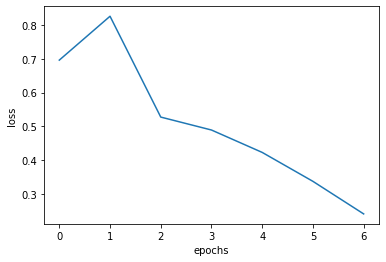

0.3092804551124573
0.2446608990430832
0.17498169839382172
0.1347551941871643
0.08130990713834763
0.056050144135951996
0.04049866273999214
Accuracy on validation set is 100.0


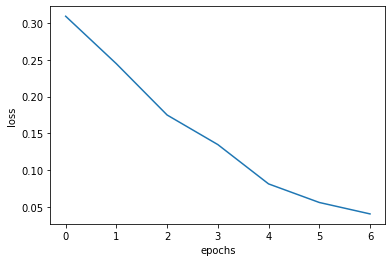

In [35]:
training_model(train_X, train_Y, learning_rate, "train", 7)
training_model(validation_X, validation_Y, learning_rate, "validation", 7)

In [36]:
def test_model(X, Y):
  model.eval()
  with torch.no_grad():
    outputs = model(X)
    accuracy = predictions(outputs.data, Y)
    print("Accuracy on test set is ", accuracy)

In [37]:
test_model(test_X, test_Y)

Accuracy on test set is  93.75


In [38]:
train_X.shape

torch.Size([1440, 3, 256, 256])